<a href="https://colab.research.google.com/github/Yash-Jumde/Colab-Notebooks/blob/main/Transfer_learning_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two main benefits of using transfer learning:
1. We can leverage an existing neural network architecture that has proven to work on similar problems.
2. Leverage a NN which has already learned patterns on similar data to our own. This means we require less custom data.

In [ ]:
# GPU
!nvidia-smi

Fri Apr 19 06:20:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We can find pre-trained models on the Tensorflow Hub.

In [ ]:
import zipfile

!wget -q  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curr

In [ ]:
# Preprocess the data.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

print('Test Images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


Setting up Callbacks.

Some of the most popular callbacks:

1. Experiment Tracking.
For this we are using tf.keras.callbacks.Tensorboard()
2. Model Checkpoints.
3. Early Stopping.

In [ ]:
# Creating a callback.
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Two models being used:
# 1. ResNetV2
# 2. EfficientNet

We can see a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com/), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

To find the appropriate model:
1. Select architecture: generally, names with larger number means a better performing model, though they can take significantly more time to compute.
2. To use the model we just need the url.

Types of transfer learning.
1. 'As is' --> take a pretrained model as it is and apply it to your task without any changes.

2. Feature extraction --> all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. Fine-tuning --> taking the weights of a pretrained model and adjust/fine-tune them to your own model.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

We will be comparing EfficientNetB0 and ResNetV250

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
def create_model(model_url, num_classes):
  # model URl: A string that as tf.hub feature extraction URL.
  # num_classes: Number of output neurons in the output layer.

  feature_extract_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,))
  # Create the model.
  model = tf.keras.Sequential([
      feature_extract_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
# The model created is uncompiled.

resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20240419-063314
Epoch 1/5
24/24 [==============================] - 23s 611ms/step - loss: 1.9685 - accuracy: 0.3520 - val_loss: 1.2643 - val_accuracy: 0.5852
Epoch 2/5
24/24 [==============================] - 10s 449ms/step - loss: 0.9226 - accuracy: 0.7507 - val_loss: 0.8861 - val_accuracy: 0.7076
Epoch 3/5
24/24 [==============================] - 11s 455ms/step - loss: 0.6260 - accuracy: 0.8200 - val_loss: 0.7722 - val_accuracy: 0.7376
Epoch 4/5
24/24 [==============================] - 13s 543ms/step - loss: 0.4836 - accuracy: 0.8707 - val_loss: 0.7369 - val_accuracy: 0.7544
Epoch 5/5
24/24 [==============================] - 11s 478ms/step - loss: 0.4003 - accuracy: 0.9040 - val_loss: 0.6965 - val_accuracy: 0.7644


A 90% accuracy on the train data with only 10% of the entire data set is remarkable.

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(loss)+1)

  # Loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

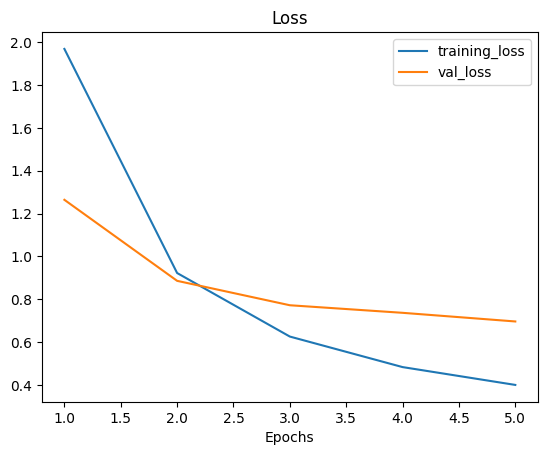

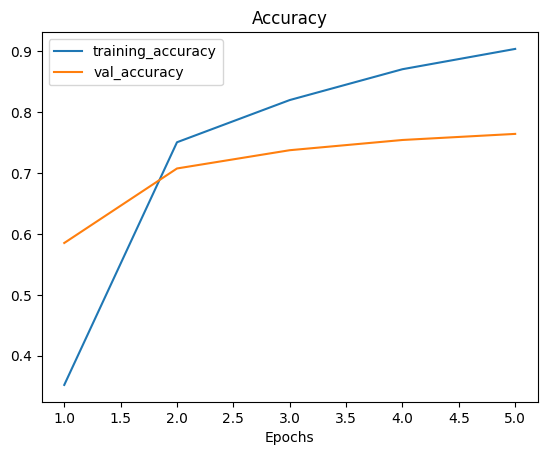

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetB0')])


Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20240419-065001
Epoch 1/5
24/24 [==============================] - 25s 579ms/step - loss: 1.8404 - accuracy: 0.4320 - val_loss: 1.2689 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 10s 438ms/step - loss: 1.0576 - accuracy: 0.7733 - val_loss: 0.8569 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 11s 472ms/step - loss: 0.7599 - accuracy: 0.8440 - val_loss: 0.6902 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 10s 430ms/step - loss: 0.6088 - accuracy: 0.8707 - val_loss: 0.6056 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 9s 394ms/step - loss: 0.5151 - accuracy: 0.8893 - val_loss: 0.5552 - val_accuracy: 0.8652


In [ ]:
# 86.53% accuracy on test_data with only 10% of the actual data is crazy.

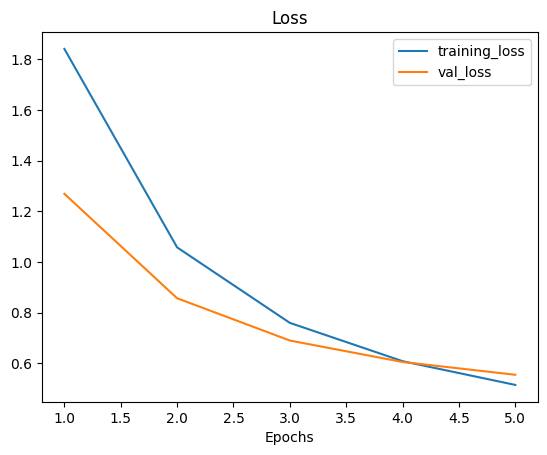

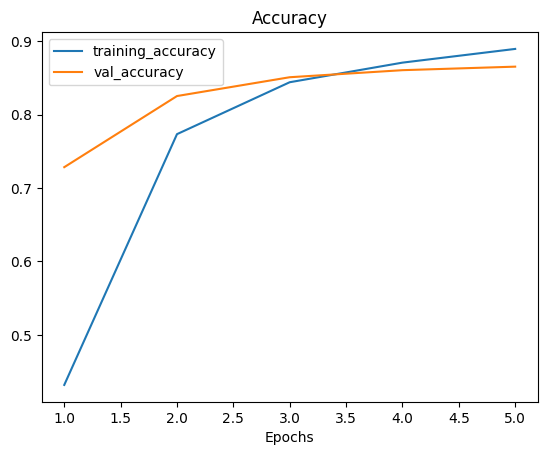

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# Increasing the number of epochs can make the model better fit.

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two diiferent TF Hub feature extraction models architecture." \
  --one_shot

2024-04-19 06:57:58.419017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 06:57:58.419079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 06:57:58.420533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 06:57:59.461737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [ ]:
# Tensorboard.dev has shut down